<a href="https://colab.research.google.com/github/pavlo-seimskyi/filler-sound-detector/blob/train-first-model/notebooks/3-train-first-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch -U
!pip install torchaudio -U
!pip3 install pickle5
!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [2]:
import os
import shutil
import pickle5 as pickle
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from torchaudio import functional as F, transforms as T
import torch
from torch.utils.data import Dataset, DataLoader

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={
        'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w',
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR
    }
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [5]:
logging.basicConfig(
    format='[%(asctime)s]–[%(message)s]',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
)

In [6]:
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())

In [7]:
# What GPU am I using?
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
device = torch.device('cuda')

In [9]:
CUTOFF_THRES = 0.8

# Copy processed data from gDrive

In [10]:
# Source
GDRIVE_FOLDER = "drive/MyDrive/data-science/filler-sound-detector/data"
FEATURES_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "features")
TARGETS_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "targets")

# Destination
FEATURES_PATH = "data/features"
TARGETS_PATH = "data/targets"

In [11]:
feature_files = os.listdir(FEATURES_SRC_FOLDER)
target_files = os.listdir(TARGETS_SRC_FOLDER)

In [12]:
os.makedirs(FEATURES_PATH, exist_ok=True)
os.makedirs(TARGETS_PATH, exist_ok=True)

In [13]:
%%time
for features, targets in zip(feature_files, target_files):
    features_src = os.path.join(FEATURES_SRC_FOLDER, features)
    features_dst = os.path.join(FEATURES_PATH, features)

    targets_src = os.path.join(TARGETS_SRC_FOLDER, targets)
    targets_dst = os.path.join(TARGETS_PATH, targets)
    shutil.copy(src=features_src, dst=features_dst)
    shutil.copy(src=targets_src, dst=targets_dst)

CPU times: user 20.2 ms, sys: 133 ms, total: 153 ms
Wall time: 266 ms


---

# Read data

In [14]:
def read_pickle(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle)

In [15]:
def convert_target_to_binary(y, threshold):
    out = y.clone()
    out[out >= threshold] = 1
    out[out < threshold] = 0
    return out

In [16]:
%%time
x = torch.tensor([])
y = torch.tensor([])

for speaker_filename in os.listdir(FEATURES_PATH):
    current_x = read_pickle(f"{FEATURES_PATH}/{speaker_filename}")
    current_y = read_pickle(f"{TARGETS_PATH}/{speaker_filename}")

    x = torch.concat((x, current_x), dim=1)
    y = torch.concat((y, current_y), dim=0)

CPU times: user 281 ms, sys: 163 ms, total: 444 ms
Wall time: 447 ms


---

# Train model

## Prepare data for training

In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x.transpose(0, 1),
    convert_target_to_binary(y, threshold=CUTOFF_THRES), 
    test_size=0.33,
    shuffle=False,
)

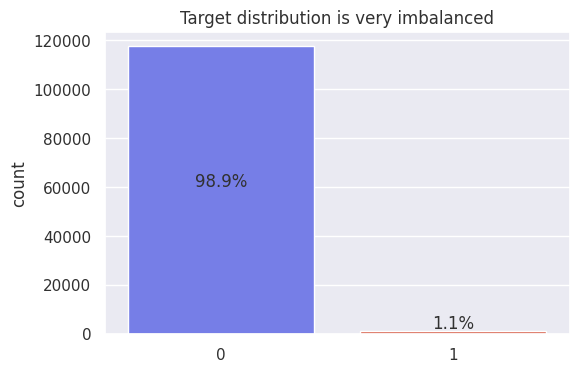

In [18]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.numpy().astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y_valid.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(s=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")
plt.show()

### Define evaluation functions

In [153]:
def evaluate(y_test, y_pred_proba, threshold):
    metrics = calculate_metrics(y_test, y_pred_proba, threshold)
    print(", ".join([f"{name}: {round(value, 3)}" for name, value in metrics.items()]))
    y_pred = convert_target_to_binary(y_pred_proba, threshold)

    y_test = y_test.cpu().numpy()
    y_pred_proba = y_pred_proba.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.tight_layout(h_pad=1, w_pad=9)
    plot_confusion_matrix(y_test, y_pred, ax=axs[0])
    plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax=axs[1])

In [157]:
def calculate_metrics(y_test, y_pred_proba, threshold):
    y_pred = convert_target_to_binary(y_pred_proba, threshold=threshold)
    return {
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "avg_precision_score": average_precision_score(y_test, y_pred_proba)
    }

In [21]:
def plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax):
    """Plot the curve with a marker pointing to the current cutoff threshold.
    :param y_test: true target variable
    :param y_pred_proba: prediction probabilities for the positive class (0.0 to 1.0)
    :param threshold: cutoff point to determine the final prediction
    :param ax: matplotlib.plt axis
    :return: None
    """
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
    ax.set_title("Precision-recall curve")
    y_pred = (y_pred_proba >= threshold).astype(float)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ax.plot(
        recall,
        precision,
        marker="x",
        color="r",
        markersize=15,
        label="chosen threshold",
    )
    ax.legend()

In [22]:
def plot_confusion_matrix(y_test, y_pred, ax):
  """
  Plot a confusion matrix on axis.
  :param y_test: true target variable
  :param y_pred: predictions
  :param ax: matplotlib.plt axis
  :return: None
  """
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
  ax.grid(False)
  ax.set_title("Confusion matrix")

## Train the baseline (LGBM)

Train a `LightGBM` model on the obtained features to see if it can pick anything from them.

In [20]:
x_train_numpy  = x_train.numpy()
x_valid_numpy = x_valid.numpy()
y_train_numpy = y_train.numpy().astype(int)
y_valid_numpy = y_valid.numpy().astype(int)

In [21]:
labels, counts = np.unique(y_train_numpy.astype(int), return_counts=True)
class_weights = {k: v for k, v in zip(np.flipud(labels), counts)}

Start training with some reasonable default parameters.

In [22]:
lgb_model = lgb.LGBMClassifier(
    is_unbalance=True,
    # scale_pos_weight=class_weights[1] / class_weights[0],
    feature_fraction=0.7,
    reg_alpha=0.7,
    reg_lambda=0.7,
    n_estimators=1000,
    random_state=42,
)

In [23]:
%%time
lgb_model = lgb_model.fit(
    X=x_train_numpy,
    y=y_train_numpy,
    eval_set=[(x_valid_numpy, y_valid_numpy), (x_train_numpy, y_train_numpy)],
    eval_names=["validation set", "training set"],
    eval_metric="f1",
    callbacks=[lgb.early_stopping(10)],
)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Number of positive: 2900, number of negative: 238557
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 241457, number of used features: 40
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012010 -> initscore=-4.409898
[LightGBM] [Info] Start training from score -4.409898
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[887]	training set's binary_loglo

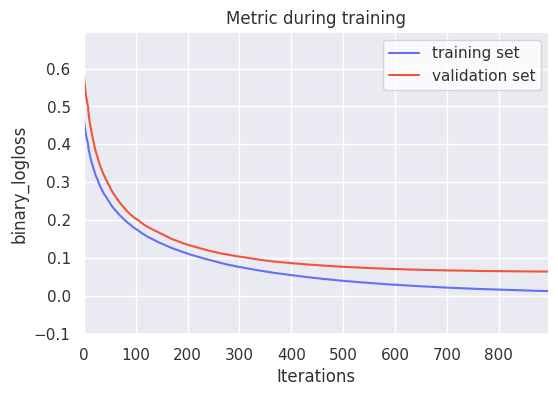

In [24]:
lgb.plot_metric(lgb_model);

In [25]:
y_pred_proba = lgb_model.predict_proba(x_valid_numpy)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


f1: 0.114, precision: 0.348, recall: 0.068, avg_precision_score: 0.103


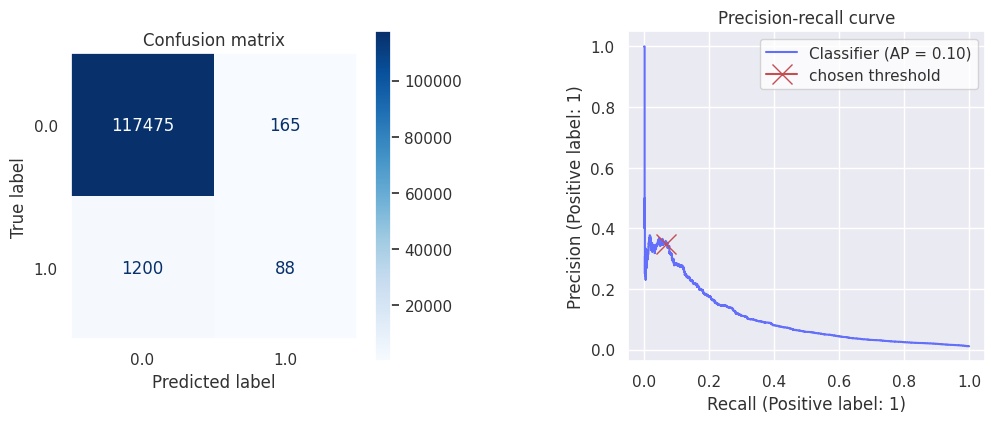

In [26]:
evaluate(y_valid, torch.Tensor(y_pred_proba), threshold=CUTOFF_THRES)

---

## Train the neural net model

### Define the architecture

In [281]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_out):
        super().__init__()
        # self.loss_fn = torch.nn.BCELoss()  # .to(device)
        # self.optimizer = None
        self.in_layer = torch.nn.Linear(n_features, n_hidden)
        self.mid_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        out = self.in_layer(x)
        out = self.relu(out)
        out = self.mid_layer(out)
        out = self.relu(out)
        out = self.out_layer(out)
        return self.softmax(out).squeeze()

In [245]:
N_FEATURES = x_train.shape[1]
N_HIDDEN = 128

---

### Create DataLoaders

In [246]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        assert x.size(0) == y.size(0), "X and y must have equal shape."
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [174]:
BATCH_SIZE = 64

In [66]:
dataset_train = CustomDataset(x_train, y_train)
dataset_valid = CustomDataset(x_valid, y_valid)

In [175]:
dl_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=False)
dl_valid = DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

### Train

Train using [this guide](https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md).

In [290]:
nn_model = MultiLayerPerceptron(
    n_features=N_FEATURES, 
    n_hidden=N_HIDDEN, 
    n_out=1,
)

In [291]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)

In [292]:
# preds = nn_model(x_train[:100, :])
# preds.shape

In [293]:
nn_model = nn_model.to(device)

In [294]:
def populate_history(history, epoch, dset, metrics):
    return pd.concat(
        (
            history, 
            pd.DataFrame(data=[{**{"epoch": epoch, "set": dset}, **metrics}])
        ), axis=0
    ).reset_index(drop=True)

In [295]:
# Training loop
history = pd.DataFrame()
best_f1 = 0

for epoch in range(10):
    # Train epoch
    nn_model.train()
    train_losses = []
    y_train_preds = torch.Tensor([])
    for inputs, targets in dl_train:
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = nn_model(inputs)  # [:, 1]
        train_loss = loss_fn(y_pred, targets)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        y_train_preds = torch.cat((y_train_preds, y_pred.cpu().detach()), axis=0)

    # Eval epoch
    nn_model.eval()
    valid_losses = []
    y_valid_preds = torch.Tensor([])
    for inputs, targets in dl_valid:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            current_y_valid_pred = nn_model(inputs)  # [:, 1]
            valid_loss = loss_fn(current_y_valid_pred, targets)
            
        valid_losses.append(valid_loss.item())
        y_valid_preds = torch.cat((y_valid_preds, current_y_valid_pred.cpu()), dim=0)

    # Track training history
    train_metrics = calculate_metrics(y_train, y_train_preds, threshold=CUTOFF_THRES)
    valid_metrics = calculate_metrics(y_valid, y_valid_preds, threshold=CUTOFF_THRES)
    train_metrics["loss"] = np.mean(train_losses)
    valid_metrics["loss"] = np.mean(valid_losses)
    history = populate_history(history, epoch=epoch, dset="train", metrics=train_metrics)
    history = populate_history(history, epoch=epoch, dset="valid", metrics=valid_metrics)

    # Print this epoch's results
    train_loss = f"Train loss: {round(np.mean(train_losses), 4)}"
    valid_loss = f"Valid loss: {round(np.mean(valid_losses), 4)}"
    train_f1 = f"Train F1: {round(train_metrics['f1'], 3)}"
    valid_f1 = f"Valid F1: {round(valid_metrics['f1'], 3)}"
    text = f"Epoch: {epoch} | {train_loss} | {valid_loss} | {train_f1} | {valid_f1}"
    print("="*len(text))
    print(text)

    if valid_metrics["f1"] > best_f1:
        torch.save(nn_model.state_dict(), 'model.bin')
        best_f1 = valid_metrics["f1"]

Epoch: 0 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 1 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 2 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 3 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 4 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 5 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 6 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 7 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 8 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021
Epoch: 9 | Train loss: 98.799 | Valid loss: 98.9174 | Train F1: 0.024 | Valid F1: 0.021


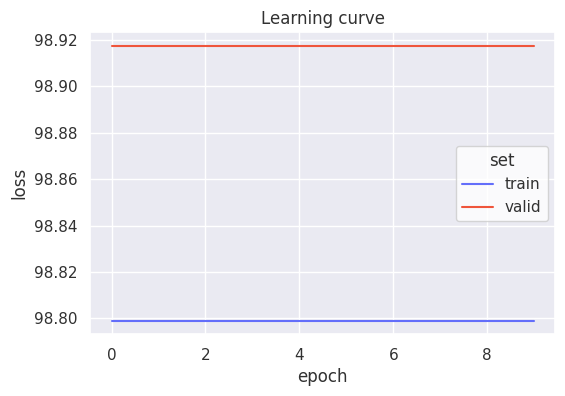

In [296]:
sns.lineplot(data=history, x="epoch", y="loss", hue="set")
plt.title("Learning curve");

f1: 0.021, precision: 0.011, recall: 1.0, avg_precision_score: 0.011


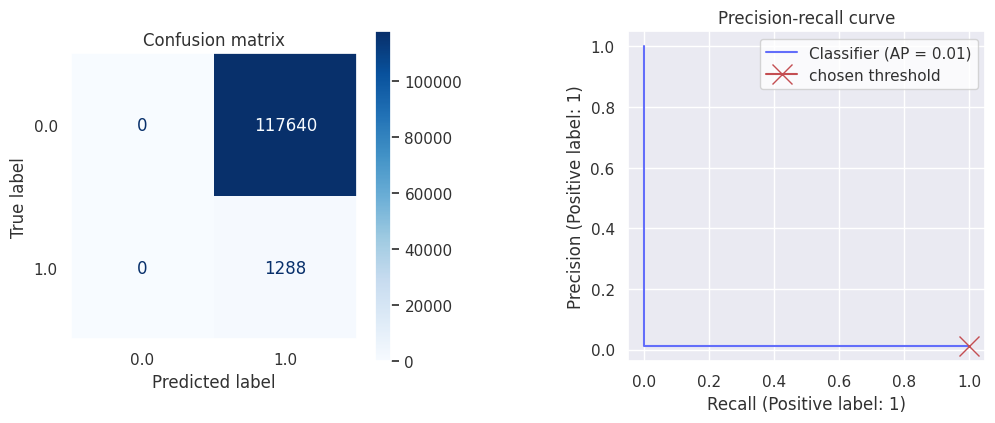

In [297]:
y_valid_preds = torch.Tensor([])
valid_losses = []

nn_model.eval()
for inputs, targets in dl_valid:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        current_y_pred = nn_model(inputs)  # [:, 1]
        loss = loss_fn(current_y_pred, targets)
        
    valid_losses.append(loss.item())
    y_valid_preds = torch.cat((y_valid_preds, current_y_pred.cpu()), dim=0)

evaluate(y_valid, y_valid_preds, threshold=CUTOFF_THRES)

---